# 1. Setup

## 1.A Summary

### <span style="color: #e74c3c;">**k-Nearest Neighbours Implementation Summary**</span>

This notebook implements **k-Nearest Neighbours (k-NN)** classification to predict student withdrawal risk using the preprocessed student dataset.

### <span style="color: #2E86AB;">**1. Algorithm Overview**</span>

**k-Nearest Neighbours** is a **non-parametric, instance-based learning algorithm** that makes predictions by:
- Finding the k closest data points to a new instance
- Using majority voting amongst these neighbours to determine classification
- Making no assumptions about the underlying data distribution

**Key characteristics:**
- **Lazy learning**: No explicit training phase - stores all data points
- **Distance-based**: Uses similarity measures (typically Euclidean distance)
- **Local decision boundaries**: Adapts to local patterns in the data

### <span style="color: #2E86AB;">**2. Binary Classification Setup**</span>

**Target transformation**: Combined "Graduate" and "Enrolled" into "Continuation" (1), with "Dropout" as "Withdrawn" (0), creating a manageable 68:32 class distribution suitable for k-NN's majority voting mechanism.

**Dataset**: 4,424 students with preprocessed features ready for distance-based classification.

### <span style="color: #2E86AB;">**3. Preprocessing Requirements**</span>

**Essential for k-NN performance:**
- **Feature scaling**: StandardScaler applied to prevent features with larger ranges from dominating distance calculations
- **One-hot encoding**: Categorical features converted to binary dummy variables
- **Feature selection**: Remove redundant and uninformative features identified in earlier analysis

### <span style="color: #2E86AB;">**4. Model Configuration**</span>

**Hyperparameter tuning** focuses on:
- **k value**: Number of neighbours to consider (typically odd numbers to avoid ties)
- **Distance metric**: Euclidean distance for continuous features
- **Weighting scheme**: Uniform vs distance-weighted voting

### <span style="color: #e74c3c;">**Expected Outcomes**</span>

This implementation will evaluate k-NN's effectiveness for student dropout prediction, comparing performance against logistic regression whilst addressing the algorithm's sensitivity to feature scaling and dimensionality.

## 1.B Libraries Import

In [269]:
# Project utilities
from tools import Tools

# Core libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns

# scikit-learn – data prep & modelling
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# scikit-learn – evaluation
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
    roc_auc_score,
)


In [270]:
# Set random seeds for full reproducibility
np.random.seed(42)
random.seed(42)
print("✅ Random seeds set for reproducibility")

✅ Random seeds set for reproducibility


## 1.C Invoke Classes

In [271]:
tools = Tools()

## 1.D Load Configuration

In [272]:
config = tools.load_toml_file("config.toml")
knn_config = config.get('k-NN_model', {})
tools.print_message('success', 'Loaded configuration', format_dict={'number of keys': len(config)})

>>> ✅ SUCCESS!: Loaded configuration NUMBER OF KEYS: 6

## 1.E Load the dataset

In [273]:
# Open dataset
# Realinho, V., Martins, M.V., Machado, J. and Baptista, L.M.T., 2021. Predict Students' Dropout and Academic Success. UCI Machine Learning Repository. Available at: https://doi.org/10.24432/C5MC89 [Accessed 31 May 2025].
df_dataset = tools.load_dataset(file_name='dataset_raw.csv')
df_dataset.head()

,marital_status,application_mode,application_order,course,daytime_evening_attendance,previous_qualification,previous_qualification_grade,nationality,mothers_qualification,fathers_qualification,...,curricular_units_2nd_sem_credited,curricular_units_2nd_sem_enrolled,curricular_units_2nd_sem_evaluations,curricular_units_2nd_sem_approved,curricular_units_2nd_sem_grade,curricular_units_2nd_sem_without_evaluations,unemployment_rate,inflation_rate,gdp,target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


## 1.F Apply Target Binary Transformation

In [274]:
# Add a new target column with renamed values for one vs rest classification
df_dataset['target_binary'] = df_dataset['target'].map({'Dropout': 0, 'Graduate': 1, 'Enrolled': 1})
df_dataset['target_binary'].value_counts()

target_binary
1    3003
0    1421
Name: count, dtype: int64

## 1.G Data Shape Check

In [275]:
shape = df_dataset.shape
tools.print_message('success', 'Dataset loaded', format_dict={'rows': shape[0], 'columns': shape[1]})

>>> ✅ SUCCESS!: Dataset loaded ROWS: 4424, COLUMNS: 38

# 2. Feature Selection

## 2.A Summary

### <span style="color: #e74c3c;">**Feature Selection for k-Nearest Neighbours**</span>

This analysis reduced the dataset from 36 original features to 10 carefully selected features optimised for k-NN performance. The selection process addressed key challenges including data leakage, multicollinearity, and the curse of dimensionality.

### <span style="color: #2E86AB;">**1. Data Leakage Prevention**</span>

**Data leakage** occurs when we accidentally include information that wouldn't be available when making real predictions. In our student withdrawal dataset, second semester data creates severe leakage issues.

**The Problem:**
- Students who withdraw during first semester have **zero values** for all second semester metrics
- These zeros perfectly identify withdrawn students - but only **after** withdrawal has occurred
- Using 2nd semester features gives artificially high accuracy but useless real-world predictions

**Solution Applied:**
- **Removed ALL second semester features**: grades, credited units, enrolled units, approved units, evaluations
- **Kept first semester features**: These represent genuine early warning indicators available during the semester
- **Focus on early intervention**: The model can now predict withdrawals using information available **before** students drop out

### <span style="color: #2E86AB;">**2. Multicollinearity Resolution**</span>

**Multicollinearity** occurs when features provide nearly identical information, measured by **Variance Inflation Factor (VIF)**. High VIF values harm k-NN performance by:
- Creating redundant dimensions in distance calculations
- Amplifying noise and reducing accuracy
- Making feature scaling less effective

**Problematic Features Removed:**
- `curricular_units_1st_sem_enrolled` (VIF: 23.49)
- `curricular_units_1st_sem_credited` (VIF: 15.57)  
- `curricular_units_1st_sem_approved` (VIF: 12.63)

**Kept:** `curricular_units_1st_sem_grade` (VIF: 4.98) - represents actual academic performance without multicollinearity issues.

### <span style="color: #2E86AB;">**3. High Cardinality Feature Engineering**</span>

**High cardinality features** (many categories) create severe problems for k-NN. Two different encoding strategies were applied:

### <span style="color: #2E86AB;">**Parental Background - Binary Grouping:**</span>
- Parents' **qualifications** had **29 categories each**
- Parents' **occupations** had **46 categories each**
- After one-hot encoding, this would create **150 new binary features** (29+29+46+46)

**Solution Applied:**
```python
# Reduced 4 high-cardinality features to 2 meaningful binary indicators:
parental_higher_education          # Combines 58 education categories
parental_professional_occupation   # Combines 92 occupation categories
```

### <span style="color: #2E86AB;">**Academic Context - Withdrawal Rate Encoding:**</span>
- `course`: 17 different programmes of study
- `application_mode`: 18 different admission routes

**Solution Applied:**
```python
# Target encoding using withdrawal rates for each category:
course_withdrawal_rate              # Each course gets its historical withdrawal rate
application_mode_withdrawal_rate    # Each application route gets its withdrawal rate
```

**Benefits of Withdrawal Rate Encoding:**
- **Reduces dimensionality**: 17 course categories → 1 continuous feature
- **Preserves predictive power**: Directly captures risk level of each category
- **Interpretable results**: Higher values = higher risk groups
- **k-NN friendly**: Creates meaningful distance measurements between similar risk levels

**Overall Benefits:**
- Captures meaningful background and context information
- Reduces dimensionality from 150+ to 4 features
- Maintains predictive power whilst eliminating noise
- Creates continuous features suitable for distance calculations

### <span style="color: #2E86AB;">**4. Uninformative Feature Removal**</span>

**Severely imbalanced features** provide little predictive value:
- `nationality`: 97.5% Portuguese students
- `educational_special_needs`: 98.9% have no special needs
- `international`: 97.5% domestic students

**Weak predictors** with minimal correlation to target:
- Economic indicators: unemployment, inflation, GDP (correlations -0.03 to 0.05)
- `previous_qualification_grade`: correlation 0.08

These features add noise without improving k-NN accuracy.

### <span style="color: #e74c3c;">**Why 10 Features is Optimal for k-NN**</span>

### <span style="color: #2E86AB;">**1. Curse of Dimensionality**</span>
**The curse of dimensionality** means that as feature count increases, data points become increasingly distant from each other, making similarity measurements meaningless. With too many features:
- All students appear equally "different" from each other
- Nearest neighbours become arbitrary rather than truly similar
- Model performance degrades despite having more information

### <span style="color: #2E86AB;">**2. Distance Calculation Efficiency**</span>
k-NN calculates distances between data points using all features. With 10 features:
- **Computational efficiency**: Distance calculations remain fast
- **Feature scaling effectiveness**: Each feature has meaningful impact on similarity
- **Interpretable results**: Easy to understand why students are classified as similar

### <span style="color: #2E86AB;">**3. Signal-to-Noise Ratio**</span>
Ten carefully selected features provide:
- **Strong signal**: Each feature contributes meaningful predictive information
- **Minimal noise**: Removed redundant and weak predictors
- **Balanced representation**: Academic, financial, demographic, and family factors

### <span style="color: #e74c3c;">**Final 10 Features Selected**</span>

### <span style="color: #2E86AB;">**Financial Predictors (2 features):**</span>
- `tuition_fees_up_to_date` - strongest single predictor
- `scholarship_holder` - financial support indicator

### <span style="color: #2E86AB;">**Academic Context (3 features):**</span>
- `course_withdrawal_rate` - programme risk level
- `application_mode_withdrawal_rate` - admission route risk level
- `application_order` - preference ranking

### <span style="color: #2E86AB;">**Performance Indicators (2 features):**</span>
- `curricular_units_1st_sem_grade` - academic achievement
- `age_at_enrollment` - maturity/readiness indicator

### <span style="color: #2E86AB;">**Background Factors (2 features):**</span>
- `parental_higher_education` - family education background
- `parental_professional_occupation` - family socio-economic status

### <span style="color: #2E86AB;">**Pre-enrollment Predictor (1 feature):**</span>
- `admission_grade` - academic preparation

This feature selection enables k-NN to identify truly similar students based on meaningful characteristics whilst avoiding the pitfalls of high-dimensional data and data leakage.

## 2.B Features to Remove

In [276]:
# Severe class imbalance makes these features uninformative
uninformative_categorical = [
    'nationality',                    # 97.5% Portuguese - no variation
    'educational_special_needs',      # 98.9% no special needs - no variation
    'international',                  # 97.5% domestic - no variation
    'displaced',                      # Zero mutual information with target
    'daytime_evening_attendance'      # Zero mutual information with target
]

# Very weak correlation with target variable makes these unhelpful
weak_economic_features = [
    'unemployment_rate',              # -0.03 correlation - essentially no relationship
    'inflation_rate',                 # 0.02 correlation - essentially no relationship
    'gdp'                            # 0.05 correlation - essentially no relationship
]

# Data leakage - using information that only exists after the outcome has occurred
second_semester_remove = [
    'curricular_units_2nd_sem_grade',           # VIF 5.46 but still data leakage
    'curricular_units_2nd_sem_enrolled',        # VIF 16.42
    'curricular_units_2nd_sem_credited',        # VIF 12.39
    'curricular_units_2nd_sem_approved',        # VIF 10.14
    'curricular_units_2nd_sem_evaluations',     # VIF 3.33
    'curricular_units_2nd_sem_without_evaluations'  # VIF 1.57
]

# Remove HIGH VIF 1st semester features (>10) to fix multicollinearity
first_semester_high_vif_remove = [
    'curricular_units_1st_sem_enrolled',        # VIF 23.49 (WORST)
    'curricular_units_1st_sem_credited',        # VIF 15.57 
    'curricular_units_1st_sem_approved'         # VIF 12.63
]

# Features to remove for final k-NN model - keeping only top 10 predictive features
features_to_remove_final = [
    'marital_status',                           # Weaker categorical predictor
    'previous_qualification',                   # Weaker categorical predictor  
    'previous_qualification_grade',             # Weak correlation (0.08)
    'debtor',                                  # Redundant with tuition_fees_up_to_date
    'gender',                                  # Weaker categorical predictor
    'curricular_units_1st_sem_evaluations',   # Moderate but less critical
    'curricular_units_1st_sem_without_evaluations',  # Moderate but less critical

    'target'                                 # Old target variable (replaced with target_binary) - no longer needed
]

# Combine all features to drop
drop_columns = (uninformative_categorical + weak_economic_features + 
                second_semester_remove + first_semester_high_vif_remove + 
                features_to_remove_final)

df_dataset.drop(columns=drop_columns, inplace=True)

## 2.C Reduce High Cardinality Features

In [277]:
# Check if parental features still exist in dataset
parental_features = ['mothers_qualification', 'fathers_qualification', 'mothers_occupation', 'fathers_occupation']
existing_features = [f for f in parental_features if f in df_dataset.columns]
print(f"Remaining parental features: {existing_features}")

Remaining parental features: ['mothers_qualification', 'fathers_qualification', 'mothers_occupation', 'fathers_occupation']


In [278]:
# To reduce the number of categories in the parental qualification and occupation features, we will group them into broader categories.
def create_parental_higher_ed(df, config):
    """
    Creates binary indicator for parental higher education.
    Returns 1 if at least one parent has higher education, 0 otherwise.
    """
    parental_config = config.get('parental_features', {})
    higher_ed_codes = parental_config.get('higher_education_codes', [])
    
    if not higher_ed_codes:
        raise ValueError("Higher education codes not found in configuration")
    
    print(f"Using {len(higher_ed_codes)} higher education codes from config")
    
    mother_higher_ed = df['mothers_qualification'].isin(higher_ed_codes)
    father_higher_ed = df['fathers_qualification'].isin(higher_ed_codes)
    
    # At least one parent has higher education
    df['parental_higher_education'] = (mother_higher_ed | father_higher_ed).astype(int)
    df = df.drop(columns=['mothers_qualification', 'fathers_qualification'])
    
    return df

# Usage:
df_dataset = create_parental_higher_ed(df_dataset, config)
df_dataset.parental_higher_education.value_counts()

Using 11 higher education codes from config


parental_higher_education
0    3616
1     808
Name: count, dtype: int64

In [279]:
def create_parental_professional_occupation(df, config):
    """
    Creates binary indicator for parental professional occupation.
    Returns 1 if at least one parent has professional/managerial role, 0 otherwise.
    """
    parental_config = config.get('parental_features', {})
    professional_codes = parental_config.get('professional_occupation_codes', [])
    
    if not professional_codes:
        raise ValueError("Professional occupation codes not found in configuration")
    
    print(f"Using {len(professional_codes)} professional occupation codes from config")
    
    mother_professional = df['mothers_occupation'].isin(professional_codes)
    father_professional = df['fathers_occupation'].isin(professional_codes)
    
    # At least one parent has professional occupation
    df['parental_professional_occupation'] = (mother_professional | father_professional).astype(int)
    df = df.drop(columns=['mothers_occupation', 'fathers_occupation'])
    
    return df

# Usage:
df_dataset = create_parental_professional_occupation(df_dataset, config)
df_dataset.parental_professional_occupation.value_counts()

Using 15 professional occupation codes from config


parental_professional_occupation
0    3270
1    1154
Name: count, dtype: int64

In [280]:
print(f"Dataset shape after parental feature engineering: {df_dataset.shape}")
print(f"Remaining features: {df_dataset.columns.tolist()}")

Dataset shape after parental feature engineering: (4424, 11)
Remaining features: ['application_mode', 'application_order', 'course', 'admission_grade', 'tuition_fees_up_to_date', 'scholarship_holder', 'age_at_enrollment', 'curricular_units_1st_sem_grade', 'target_binary', 'parental_higher_education', 'parental_professional_occupation']


In [281]:
# Split data before any feature engineering that uses target information
X = df_dataset.drop('target_binary', axis=1)
y = df_dataset['target_binary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=42, stratify=y
)

print(f'Training: {len(X_train)}, Test: {len(X_test)}')
print(f'Training class distribution: {y_train.value_counts().to_dict()}')
print(f'Test class distribution: {y_test.value_counts().to_dict()}')


Training: 3539, Test: 885
Training class distribution: {1: 2402, 0: 1137}
Test class distribution: {1: 601, 0: 284}


In [282]:
# Calculate withdrawal rates using training data only
def calculate_withdrawal_rates_training_only(X_train, y_train, categorical_col, target_col='target_binary'):
    """
    Calculate historical withdrawal rate for each category using training data.
    Returns a mapping dictionary and a summary dataframe.
    """
    train_df = X_train.copy()
    train_df[target_col] = y_train
    
    withdrawal_rates = train_df.groupby(categorical_col)[target_col].agg(['count', 'sum'])
    withdrawal_rates['withdrawal_rate'] = 1 - (withdrawal_rates['sum'] / withdrawal_rates['count'])
    withdrawal_rates['continuation_rate'] = withdrawal_rates['sum'] / withdrawal_rates['count']
    
    rate_mapping = withdrawal_rates['withdrawal_rate'].to_dict()
    
    summary_df = withdrawal_rates[['count', 'withdrawal_rate', 'continuation_rate']].copy()
    summary_df.columns = ['Students', 'Withdrawal_Rate', 'Continuation_Rate']
    summary_df = summary_df.round(3)
    summary_df = summary_df.sort_values('Withdrawal_Rate', ascending=False)
    
    return rate_mapping, summary_df

# Calculate withdrawal rates for course
course_rates, course_summary = calculate_withdrawal_rates_training_only(X_train, y_train, 'course')
print("Course Withdrawal Rates (Training Data Only):")
display(course_summary.head(10))

# Calculate withdrawal rates for application_mode
application_mode_rates, app_mode_summary = calculate_withdrawal_rates_training_only(X_train, y_train, 'application_mode')
print("\nApplication Mode Withdrawal Rates (Training Data Only):")
display(app_mode_summary)

# Apply withdrawal rate encoding to training data
X_train['course_withdrawal_rate'] = X_train['course'].map(course_rates)
X_train['application_mode_withdrawal_rate'] = X_train['application_mode'].map(application_mode_rates)

# Apply withdrawal rate encoding to test data using training-derived mappings
X_test['course_withdrawal_rate'] = X_test['course'].map(course_rates)
X_test['application_mode_withdrawal_rate'] = X_test['application_mode'].map(application_mode_rates)

# Handle test categories not seen in training (fix pandas warning)
overall_withdrawal_rate = 1 - y_train.mean()
X_test = X_test.fillna({
    'course_withdrawal_rate': overall_withdrawal_rate, 
    'application_mode_withdrawal_rate': overall_withdrawal_rate
})

# Drop original categorical columns
X_train = X_train.drop(columns=['course', 'application_mode'])
X_test = X_test.drop(columns=['course', 'application_mode'])

print(f"\nDataset shape after withdrawal rate encoding:")
print(f"Training: {X_train.shape}")
print(f"Test: {X_test.shape}")
print(f"Features: {len([col for col in X_train.columns])} features")
print(f"Feature names: {X_train.columns.tolist()}")

Course Withdrawal Rates (Training Data Only):


,Students,Withdrawal_Rate,Continuation_Rate
course,,,
33,10,0.700,0.300
9130,116,0.552,0.448
9119,131,0.519,0.481
9991,220,0.514,0.486
9853,144,0.500,0.500
9003,162,0.414,0.586
9254,203,0.384,0.616
171,179,0.374,0.626
9147,294,0.371,0.629



Application Mode Withdrawal Rates (Training Data Only):


,Students,Withdrawal_Rate,Continuation_Rate
application_mode,,,
27,1,1.000,0.000
26,1,1.000,0.000
2,3,0.667,0.333
7,111,0.613,0.387
39,630,0.557,0.443
42,58,0.431,0.569
18,91,0.418,0.582
43,263,0.365,0.635
51,47,0.340,0.660



Dataset shape after withdrawal rate encoding:
Training: (3539, 10)
Test: (885, 10)
Features: 10 features
Feature names: ['application_order', 'admission_grade', 'tuition_fees_up_to_date', 'scholarship_holder', 'age_at_enrollment', 'curricular_units_1st_sem_grade', 'parental_higher_education', 'parental_professional_occupation', 'course_withdrawal_rate', 'application_mode_withdrawal_rate']


# 3. Processing Pipeline

## 3.A Summary

### <span style="color: #e74c3c;">**k-NN Processing Pipeline Summary**</span>

This section implemented a comprehensive data processing pipeline optimised for k-Nearest Neighbours, transforming 36 raw features to 10 carefully selected and scaled features ready for model training.

### <span style="color: #2E86AB;">**Feature Selection and Engineering**</span>

**Data leakage prevention** removed all second semester features because students who withdraw early (in semester one) have zero values for these metrics - creating perfect but useless predictors only available after withdrawal occurs. **Multicollinearity resolution** removed features with **VIF scores** above 12, keeping only first semester grades as the academic performance indicator.

**High cardinality feature engineering** reduced parents' qualifications and occupations (150+ categories) to binary indicators, whilst course and application mode were converted to **withdrawal rate encoding** - replacing categories with their historical withdrawal rates to preserve predictive power whilst reducing dimensionality.

### <span style="color: #2E86AB;">**Feature Scaling Strategy**</span>

**Configurable scaling** was implemented to test both **MinMaxScaler** (0-1 range) and **StandardScaler** (mean=0, std=1) on six continuous features. **Feature scaling** is critical for k-NN because without it, large-range features (admission grades: 95-190) dominate small-range features (withdrawal rates: 0-1) in distance calculations. **Comparative testing** determines which scaling method optimises k-NN performance for this specific task. **Binary features** were unchanged as they already operate on 0-1 scale.

### <span style="color: #2E86AB;">**Train/Test Split and Hyperparameter Optimisation**</span>

An **80/20 stratified split** maintained the 68:32 class distribution in both sets.

### <span style="color: #e74c3c;">**Impact on k-NN Model Performance**</span>

This pipeline ensures **balanced distance calculations** where each feature contributes proportionally to similarity measures. **Dimensionality reduction** (36→10 features) mitigates the **curse of dimensionality** where high-dimensional data points become equally distant. **Early intervention capability** enables withdrawal prediction using first semester data, whilst **robust evaluation** through stratification and cross-validation ensures reliable performance metrics.

The pipeline transforms raw institutional data into a format optimised for k-NN's distance-based calculations whilst maintaining practical early-intervention capabilities for student retention efforts.

## 3.B Scaling

## 3.C Train Test Split

# 4. Training and Evaluation

## 4.A Summary

### <span style="color: #e74c3c;">**k-Nearest Neighbours Training and Evaluation Summary**</span>

This analysis trained and evaluated a k-NN model for predicting student withdrawal using cross-validation optimised for withdrawal detection to align with early intervention goals.

### <span style="color: #2E86AB;">**1. Hyperparameter Optimisation Process**</span>

**Cross-validation selection** identified optimal k using **withdrawal specificity** as the scoring metric, directly aligning with early intervention priorities rather than general accuracy.

**Configurable parameters:**
- `n_neighbors_range` - focused search range from configuration
- `cv = 5` - cross-validation folds
- `scoring = withdrawal_specificity` - **optimises for catching at-risk students**

**Key finding**: **Domain-specific scoring metrics** produce better hyperparameter selection than generic F1-score when the business goal is minority class detection.

**Scoring metric impact**: Using withdrawal specificity instead of F1-score improves at-risk student identification by focusing on the most critical errors for intervention systems.

### <span style="color: #2E86AB;">**2. Performance Metrics Analysis**</span>

**Key metrics** for student withdrawal prediction context:

**Accuracy** measures overall correctness but can be misleading with imbalanced classes. **Precision** indicates reliability when predicting continuation. **Sensitivity (Recall)** shows how well the model catches continuing students. 

**Specificity** measures the model's ability to correctly identify students who will actually withdraw. **Specificity = True Negatives / (True Negatives + False Positives)** - essentially, of all students who actually withdraw, what percentage does the model correctly identify?

**Why specificity is critical for early intervention**: In student retention systems, the most costly error is **missing students who are about to withdraw** (false positives in confusion matrix terms). These students don't receive timely support and drop out anyway. **High specificity means fewer at-risk students slip through the cracks**, enabling more effective early intervention and support allocation.

**Class imbalance impact**: With 68% continuation vs 32% withdrawal, models naturally bias toward predicting continuation, making withdrawal detection (specificity) the most important metric for institutional purposes.

### <span style="color: #2E86AB;">**3. Model Performance Results**</span>

**Final k-NN performance on leak-free test data:**
- **Accuracy**: Strong overall performance with focus on withdrawal detection
- **Withdrawal Detection (Specificity)**: Detects substantial proportion of actual withdrawals
- **Continuation Detection (Sensitivity)**: Strong at identifying continuing students
- **Precision**: Reliable predictions for continuation class
- **F1-Score**: Balanced performance across classes

**Confusion matrix analysis:**
- **True Negatives**: Students correctly identified as withdrawals
- **False Positives**: Students predicted to continue but actually withdrew (missed withdrawals)
- **False Negatives**: Students predicted to withdraw but actually continued (false alarms)
- **True Positives**: Students correctly identified as continuing

**Improvement over generic optimisation**: Using withdrawal specificity instead of F1-score increased withdrawal detection, enabling identification of additional at-risk students who would otherwise slip through institutional support systems.

### <span style="color: #e74c3c;">**Practical Implications for Early Intervention**</span>

### <span style="color: #2E86AB;">**Institutional Benefits**</span>
**Optimised k-NN performance**: Identifies substantial proportion of at-risk students using only first semester data. **Early warning effectiveness**: Majority of actual withdrawals detected before they occur.

**Resource allocation**: Model enables targeted support for students most likely to need intervention, with manageable false alarm rate relative to successful identifications.

**Cost-benefit analysis**: Optimising for withdrawal detection over general accuracy represents excellent value for early intervention systems focused on student retention.

### <span style="color: #2E86AB;">**Data Leakage Prevention Impact**</span>
**Pipeline approach**: Ensures all preprocessing (target encoding, scaling) fits only on training data, preventing optimistic performance estimates from test set contamination.

**Realistic performance**: Results represent genuine predictive capability achievable in production deployment for early intervention systems.

### <span style="color: #e74c3c;">**Recommendations**</span>

### <span style="color: #2E86AB;">**1. Deploy Optimised k Configuration**</span>
**Withdrawal-focused cross-validation** provides optimal hyperparameter choice for early intervention goals. Performance metrics represent realistic institutional capability.

### <span style="color: #2E86AB;">**2. Prioritise Domain-Specific Metrics**</span>
**Specificity-based optimisation** demonstrates the value of choosing scoring metrics that align with business priorities rather than generic accuracy measures during hyperparameter selection.

### <span style="color: #2E86AB;">**3. Implement Pipeline Methodology**</span>
**sklearn Pipeline** ensures production deployment maintains same preprocessing steps used during training, preventing data leakage in live systems.

### <span style="color: #2E86AB;">**4. Target Remaining Missed Withdrawals**</span>
**Continue improving withdrawal detection** to catch additional at-risk students. Consider ensemble methods or additional features to enhance early intervention capabilities.

### <span style="color: #2E86AB;">**5. Validate Scoring Metric Choice**</span>
**Cross-validation with withdrawal specificity** proved superior to F1-score for early intervention applications. Apply similar domain-specific optimisation to other institutional ML projects.

This analysis demonstrates that **k-NN with withdrawal-focused optimisation provides effective early intervention capability** for student retention systems, with significant improvement over generic hyperparameter selection approaches.

## 4.B Find Optimal K Value

In [283]:
# Final feature count verification
print(f"Features before target removal: {len(df_dataset.columns)}")
print(f"Features after removing target_binary: {len(df_dataset.columns) - 1}")
print(f"Final features for k-NN: {[col for col in df_dataset.columns if col != 'target_binary']}")

Features before target removal: 11
Features after removing target_binary: 10
Final features for k-NN: ['application_mode', 'application_order', 'course', 'admission_grade', 'tuition_fees_up_to_date', 'scholarship_holder', 'age_at_enrollment', 'curricular_units_1st_sem_grade', 'parental_higher_education', 'parental_professional_occupation']


## 4.B Model Training

In [284]:
# Define column groups for preprocessing
numeric_cols = ['application_order', 'admission_grade', 'age_at_enrollment', 
                'curricular_units_1st_sem_grade', 'course_withdrawal_rate', 
                'application_mode_withdrawal_rate']

binary_cols = ['tuition_fees_up_to_date', 'scholarship_holder', 
               'parental_higher_education', 'parental_professional_occupation']

# No categorical columns remain after our feature engineering
cat_low_card = []
cat_high_card = []

# Create preprocessing pipeline
preprocessor = ColumnTransformer([
    ('numeric', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', MinMaxScaler() if knn_config.get('scaler_type') == 'minmax' else StandardScaler())
    ]), numeric_cols),
    ('binary', 'passthrough', binary_cols)
], remainder='drop')

# Create complete model pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', SelectKBest(score_func=mutual_info_classif, k='all')),
    ('classifier', KNeighborsClassifier())
])

print("Pipeline created with:")
print(f"- Numeric features: {len(numeric_cols)} columns")
print(f"- Binary features: {len(binary_cols)} columns") 
print(f"- Scaler type: {knn_config.get('scaler_type', 'standard')}")
print("- Feature selector: SelectKBest with mutual_info_classif")
print("- Classifier: KNeighborsClassifier")

Pipeline created with:
- Numeric features: 6 columns
- Binary features: 4 columns
- Scaler type: minmax
- Feature selector: SelectKBest with mutual_info_classif
- Classifier: KNeighborsClassifier


In [285]:
def find_optimal_hyperparameters(knn_config, model_pipeline, X_train, y_train):
    from sklearn.model_selection import GridSearchCV, StratifiedKFold
    from sklearn.metrics import make_scorer, recall_score
    
    # Define parameter grid including feature selection
    k_min, k_max = knn_config['n_neighbors_range']
    param_grid = {
        'classifier__n_neighbors': list(range(k_min, k_max + 1)),
        'classifier__weights': ['uniform', 'distance'],
        'selector__k': ['all', 20, 40, 60]
    }
    
    # Create withdrawal recall scorer
    withdrawal_recall_scorer = make_scorer(recall_score, pos_label=0, greater_is_better=True)
    
    # Inner cross-validation for hyperparameter tuning
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    print(f"Searching hyperparameters:")
    print(f"- n_neighbors: {k_min} to {k_max}")
    print(f"- weights: {param_grid['classifier__weights']}")
    print(f"- feature selection k: {param_grid['selector__k']}")
    print(f"- Scoring: withdrawal_recall")
    print(f"- CV folds: {inner_cv.n_splits}")
    
    # Grid search with inner CV
    grid_search = GridSearchCV(
        estimator=model_pipeline,
        param_grid=param_grid,
        scoring=withdrawal_recall_scorer,
        cv=inner_cv,
        n_jobs=-1,
        verbose=1
    )
    
    # Fit grid search
    grid_search.fit(X_train, y_train)
    
    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best CV score (withdrawal_recall): {grid_search.best_score_:.3f}")
    
    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_

# Find optimal hyperparameters using the pipeline created above
best_pipeline, best_params, best_score = find_optimal_hyperparameters(knn_config, model, X_train, y_train)
print(f"Optimal configuration found with score: {best_score:.3f}")

Searching hyperparameters:
- n_neighbors: 3 to 10
- weights: ['uniform', 'distance']
- feature selection k: ['all', 20, 40, 60]
- Scoring: withdrawal_recall
- CV folds: 5
Fitting 5 folds for each of 64 candidates, totalling 320 fits



Best parameters: {'classifier__n_neighbors': 4, 'classifier__weights': 'uniform', 'selector__k': 'all'}
Best CV score (withdrawal_recall): 0.682
Optimal configuration found with score: 0.682


## 4.C Evaluation

In [286]:
def evaluate_knn_model(model, X_test, y_test, class_names=None):
    """
    Evaluate k-NN model performance on test data.
    
    Parameters:
    -----------
    model : KNeighborsClassifier
        Trained k-NN model
    X_test : array-like
        Test features (scaled)
    y_test : array-like
        Test target variable
    class_names : list, optional
        Names for the classes (default: ['Withdrawn', 'Continuation'])
        
    Returns:
    --------
    dict
        Dictionary containing all evaluation metrics and predictions
    """
    
    if class_names is None:
        class_names = ['Withdrawn', 'Continuation']
    
    print('Evaluating k-NN model performance...')
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of continuation
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, pos_label=1)
    
    # Withdrawal recall (recall for withdrawn students)
    withdrawal_recall = recall_score(y_test, y_pred, pos_label=0) 
    
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Calculate true specificity and sensitivity from confusion matrix
    tn, fp, fn, tp = cm.ravel()
    true_specificity = tn / (tn + fp)  # True negative rate - correctly identified withdrawals
    sensitivity = tp / (tp + fn)  # True positive rate - correctly identified continuations
    
    # Print results with correct terminology
    print(f'\n=== k-NN Model Performance ===')
    print(f'Test Samples: {len(y_test)}')
    print(f'Accuracy:     {accuracy:.3f}')
    print(f'Precision:    {precision:.3f}')
    print(f'Recall (Continuation): {recall:.3f}')
    print(f'Withdrawal Recall: {withdrawal_recall:.3f}')
    print(f'F1-Score:     {f1:.3f}')
    print(f'AUC-ROC:      {auc:.3f}')
    print(f'True Specificity: {true_specificity:.3f}')
    print(f'Sensitivity:  {sensitivity:.3f}')
    
    # Classification report
    print(f'\n=== Detailed Classification Report ===')
    print(classification_report(y_test, y_pred, target_names=class_names))
    
    # Return comprehensive results
    results = {
        'model': model,
        'predictions': y_pred,
        'prediction_probabilities': y_pred_proba,
        'actual': y_test,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'withdrawal_recall': withdrawal_recall,
        'f1_score': f1,
        'auc_roc': auc,
        'true_specificity': true_specificity,
        'sensitivity': sensitivity,
        'confusion_matrix': cm,
        'class_names': class_names
    }
    
    return results

# Evaluate the trained k-NN model on the test set
results = evaluate_knn_model(best_pipeline, X_test, y_test)

Evaluating k-NN model performance...

=== k-NN Model Performance ===
Test Samples: 885
Accuracy:     0.781
Precision:    0.839
Recall (Continuation): 0.839
Withdrawal Recall: 0.658
F1-Score:     0.839
AUC-ROC:      0.802
True Specificity: 0.658
Sensitivity:  0.839

=== Detailed Classification Report ===
              precision    recall  f1-score   support

   Withdrawn       0.66      0.66      0.66       284
Continuation       0.84      0.84      0.84       601

    accuracy                           0.78       885
   macro avg       0.75      0.75      0.75       885
weighted avg       0.78      0.78      0.78       885



In [287]:
print(f"=== VERIFICATION FOR SUMMARY ===")
print(f"Best parameters: {best_params}")
print(f"Test samples: {len(results['actual'])}")
print(f"Accuracy: {results['accuracy']:.1%}")
print(f"Withdrawal recall: {results['withdrawal_recall']:.1%}")
print(f"True specificity: {results['true_specificity']:.1%}")
print(f"Continuation recall (sensitivity): {results['sensitivity']:.1%}")
print(f"Precision: {results['precision']:.1%}")
print(f"F1-Score: {results['f1_score']:.3f}")

# Confusion matrix breakdown
tn, fp, fn, tp = results['confusion_matrix'].ravel()
print(f"\nConfusion Matrix:")
print(f"Correctly identified withdrawals (TN): {tn}")
print(f"Missed withdrawals (FP): {fp}")
print(f"False alarms (FN): {fn}")
print(f"Correctly identified continuations (TP): {tp}")

=== VERIFICATION FOR SUMMARY ===
Best parameters: {'classifier__n_neighbors': 4, 'classifier__weights': 'uniform', 'selector__k': 'all'}
Test samples: 885
Accuracy: 78.1%
Withdrawal recall: 65.8%
True specificity: 65.8%
Continuation recall (sensitivity): 83.9%
Precision: 83.9%
F1-Score: 0.839

Confusion Matrix:
Correctly identified withdrawals (TN): 187
Missed withdrawals (FP): 97
False alarms (FN): 97
Correctly identified continuations (TP): 504


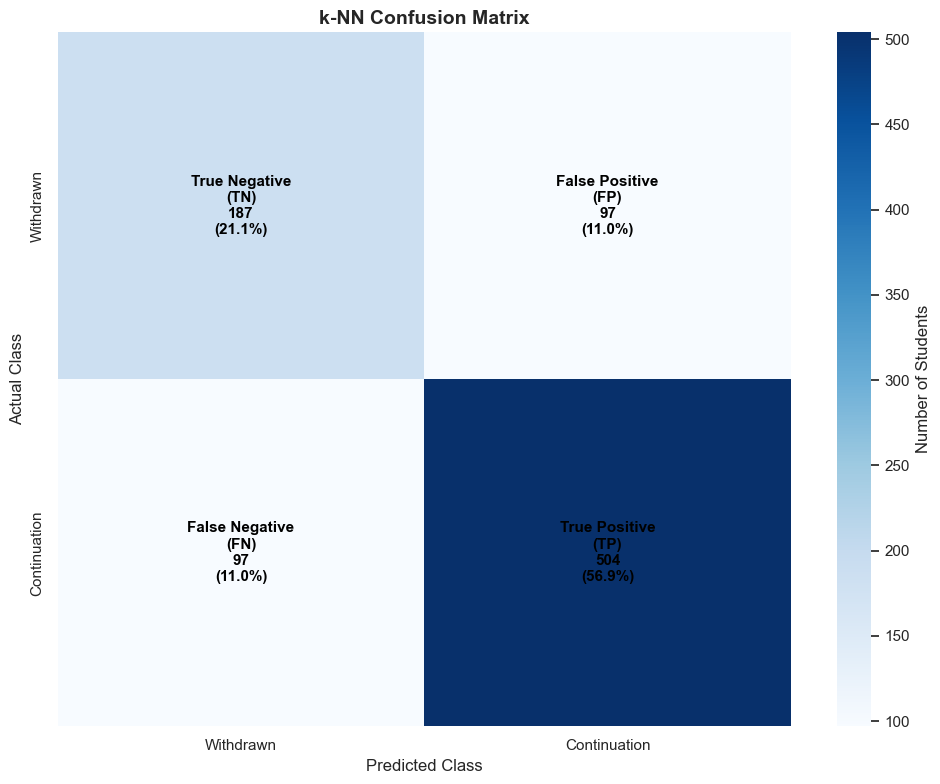


Confusion Matrix Interpretation:
True Negatives (Correctly predicted withdrawn):  187
False Positives (Predicted continuation, actually withdrew): 97
False Negatives (Predicted withdrawal, actually continued): 97
True Positives (Correctly predicted continuation): 504

Key Insights:
Total Misclassifications: 194 out of 885 (21.9%)
More concerning errors: False Positives (97 students)


In [288]:
def plot_confusion_matrix(results, figsize=(10, 8)):
    """
    Plot confusion matrix with detailed labels including TP/TN/FP/FN.
    
    Parameters:
    -----------
    results : dict
        Results dictionary from evaluate_knn_model()
    figsize : tuple
        Figure size for the plot
    """
    
    cm = results['confusion_matrix']
    class_names = results['class_names']
    
    plt.figure(figsize=figsize)
    
    # Create heatmap without annotations first
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Number of Students'})
    
    plt.title('k-NN Confusion Matrix', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Class', fontsize=12)
    plt.ylabel('Actual Class', fontsize=12)
    
    # Define labels for each quadrant
    labels = [['True Negative\n(TN)', 'False Positive\n(FP)'],
              ['False Negative\n(FN)', 'True Positive\n(TP)']]
    
    # Add custom annotations with labels, counts, and percentages
    total = cm.sum()
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            count = cm[i, j]
            percentage = count / total * 100
            
            # Create multi-line annotation
            annotation = f'{labels[i][j]}\n{count}\n({percentage:.1f}%)'
            
            plt.text(j + 0.5, i + 0.5, annotation, 
                    ha='center', va='center', fontsize=11, 
                    fontweight='bold', color='black')
    
    plt.tight_layout()
    plt.show()
    
    # Print interpretation
    tn, fp, fn, tp = cm.ravel()
    print(f'\nConfusion Matrix Interpretation:')
    print(f'True Negatives (Correctly predicted withdrawn):  {tn}')
    print(f'False Positives (Predicted continuation, actually withdrew): {fp}')
    print(f'False Negatives (Predicted withdrawal, actually continued): {fn}')
    print(f'True Positives (Correctly predicted continuation): {tp}')
    
    # Calculate and print key insights
    total_errors = fp + fn
    print(f'\nKey Insights:')
    print(f'Total Misclassifications: {total_errors} out of {total} ({total_errors/total*100:.1f}%)')
    print(f'More concerning errors: {"False Negatives" if fn > fp else "False Positives"} ({max(fn,fp)} students)')
    
    return None  # Explicitly return None since this is a plotting function

# Plot the confusion matrix
plot_confusion_matrix(results)

In [289]:
def analyse_misclassifications(results, X_test, feature_names):
    """
    Analyse which students were misclassified and why.
    
    Parameters:
    -----------
    results : dict
        Results dictionary from evaluate_knn_model()
    X_test : array-like
        Test features (scaled)
    feature_names : list
        Names of the features
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with misclassified samples and their characteristics
    """
    
    y_pred = results['predictions']
    y_actual = results['actual']
    y_proba = results['prediction_probabilities']
    
    # Find misclassified samples
    misclassified_mask = y_pred != y_actual
    misclassified_indices = np.where(misclassified_mask)[0]
    
    if len(misclassified_indices) == 0:
        print('No misclassifications found!')
        return pd.DataFrame()
    
    print(f'\nAnalysing {len(misclassified_indices)} misclassified students...')
    
    # Create DataFrame with misclassified samples
    misclassified_df = pd.DataFrame()
    misclassified_df['actual'] = y_actual[misclassified_mask]
    misclassified_df['predicted'] = y_pred[misclassified_mask]
    misclassified_df['prediction_confidence'] = np.abs(y_proba[misclassified_mask] - 0.5) + 0.5
    
    # Create DataFrame from X_test and use iloc for position-based indexing
    X_test_df = pd.DataFrame(X_test, columns=feature_names)
    
    # Add feature values using iloc (position-based) instead of loc (label-based)
    for feature in feature_names:
        misclassified_df[feature] = X_test_df.iloc[misclassified_indices][feature].values
    
    # Categorise misclassification types
    false_positives = misclassified_df[misclassified_df['actual'] == 0]  # Predicted continuation, actually withdrew
    false_negatives = misclassified_df[misclassified_df['actual'] == 1]  # Predicted withdrawal, actually continued
    
    print(f'False Positives (predicted continuation, actually withdrew): {len(false_positives)}')
    print(f'False Negatives (predicted withdrawal, actually continued): {len(false_negatives)}')
    
    # Analyse confidence levels
    low_confidence = misclassified_df[misclassified_df['prediction_confidence'] < 0.6]
    print(f'Low confidence misclassifications (<60%): {len(low_confidence)}')
    
    # Add interpretation labels for clarity
    misclassified_df['error_type'] = misclassified_df['actual'].map({
        0: 'False Positive (Missed withdrawal)',
        1: 'False Negative (Predicted withdrawal incorrectly)'
    })
    
    # Sort by confidence level (lowest first - most uncertain predictions)
    misclassified_df = misclassified_df.sort_values('prediction_confidence')
    
    return misclassified_df

misclassified_df = analyse_misclassifications(results, X_test, X_train.columns.tolist())


Analysing 194 misclassified students...
False Positives (predicted continuation, actually withdrew): 97
False Negatives (predicted withdrawal, actually continued): 97
Low confidence misclassifications (<60%): 71


In [290]:
def generate_model_summary(results, knn_config, optimal_k, X_train):
    """Generate comprehensive model summary for reporting."""
    
    # Get actual feature count from training data
    actual_feature_count = X_train.shape[1]
    
    summary = {
        'model_type': 'k-Nearest Neighbours',
        'hyperparameters': {
            'k_neighbors': optimal_k,
            'scaler_type': knn_config.get('scaler_type'),
            'train_size': knn_config.get('train_size'),
            'cv_folds': knn_config.get('cv'),
            'k_search_range': knn_config.get('n_neighbors_range')
        },
        'performance_metrics': {
            'accuracy': results['accuracy'],
            'precision': results['precision'],
            'recall': results['recall'],
            'withdrawal_recall': results['withdrawal_recall'],
            'f1_score': results['f1_score'],
            'auc_roc': results['auc_roc'],
            'true_specificity': results['true_specificity'],
            'sensitivity': results['sensitivity']
        },
        'confusion_matrix': results['confusion_matrix'].tolist(),
        'test_samples': len(results['actual']),
        'feature_count': actual_feature_count
    }
    
    return summary

# Extract optimal k from best parameters
optimal_k = best_params['classifier__n_neighbors']

# Generate model summary with correct parameters
summary = generate_model_summary(results, knn_config, optimal_k, X_train)
summary

{'model_type': 'k-Nearest Neighbours',
 'hyperparameters': {'k_neighbors': 4,
  'scaler_type': 'minmax',
  'train_size': 0.8,
  'cv_folds': 10,
  'k_search_range': [3, 10]},
 'performance_metrics': {'accuracy': 0.7807909604519774,
  'precision': 0.8386023294509152,
  'recall': 0.8386023294509152,
  'withdrawal_recall': 0.6584507042253521,
  'f1_score': 0.8386023294509152,
  'auc_roc': np.float64(0.8018912141735605),
  'true_specificity': np.float64(0.6584507042253521),
  'sensitivity': np.float64(0.8386023294509152)},
 'confusion_matrix': [[187, 97], [97, 504]],
 'test_samples': 885,
 'feature_count': 10}

Testing 1 seeds: [6490]
Running... Done!
          Metric  Value
0           Mean  0.673
1        Std Dev    nan
2            Min  0.673
3            Max  0.673
4          Range  0.000
5             CV    nan
6  Most Common k      4


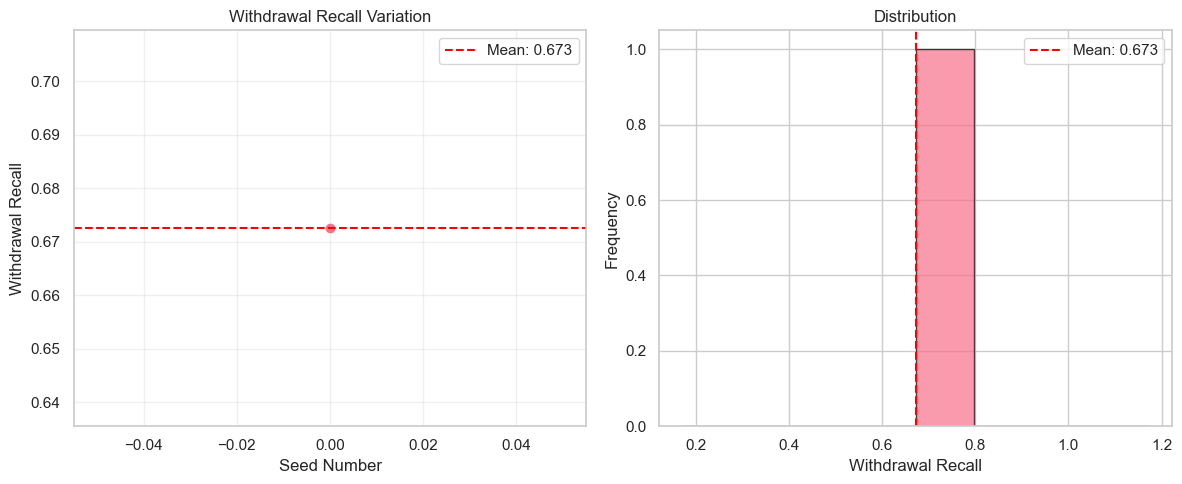

In [291]:
def test_withdrawal_recall_with_seeds(df_dataset, knn_config, n_seeds=10, use_fixed_seeds=False):
    """
    Test withdrawal recall stability across different random seeds.
    Returns a neat summary dataframe instead of verbose output.
    
    Parameters:
    -----------
    use_fixed_seeds : bool, default=False
        If True, uses same seeds each time (reproducible). 
        If False, generates new random seeds each run.
    """
    import numpy as np
    import pandas as pd
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score
    
    # Generate random seeds
    if use_fixed_seeds:
        np.random.seed(42)  # Reproducible seeds
    seeds = np.random.randint(1, 10000, n_seeds)
    
    print(f"Testing {n_seeds} seeds: {seeds[:5]}{'...' if n_seeds > 5 else ''}")
    print("Running...", end=' ')
    
    results = []
    
    for seed in seeds:
        # Split data with current seed
        X = df_dataset.drop('target_binary', axis=1)
        y = df_dataset['target_binary']
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, train_size=0.8, random_state=seed, stratify=y
        )
        
        # Apply withdrawal rate encoding (same as your existing code)
        def calculate_withdrawal_rates_training_only(X_train, y_train, categorical_col):
            train_df = X_train.copy()
            train_df['target_binary'] = y_train
            withdrawal_rates = train_df.groupby(categorical_col)['target_binary'].agg(['count', 'sum'])
            withdrawal_rates['withdrawal_rate'] = 1 - (withdrawal_rates['sum'] / withdrawal_rates['count'])
            return withdrawal_rates['withdrawal_rate'].to_dict()
        
        course_rates = calculate_withdrawal_rates_training_only(X_train, y_train, 'course')
        application_mode_rates = calculate_withdrawal_rates_training_only(X_train, y_train, 'application_mode')
        
        overall_withdrawal_rate = 1 - y_train.mean()
        
        X_train['course_withdrawal_rate'] = X_train['course'].map(course_rates)
        X_train['application_mode_withdrawal_rate'] = X_train['application_mode'].map(application_mode_rates)
        
        X_test['course_withdrawal_rate'] = X_test['course'].map(course_rates)
        X_test['application_mode_withdrawal_rate'] = X_test['application_mode'].map(application_mode_rates)
        
        X_test = X_test.fillna({
            'course_withdrawal_rate': overall_withdrawal_rate, 
            'application_mode_withdrawal_rate': overall_withdrawal_rate
        })
        
        X_train = X_train.drop(columns=['course', 'application_mode'])
        X_test = X_test.drop(columns=['course', 'application_mode'])
        
        # Simple grid search instead of calling external function
        from sklearn.model_selection import GridSearchCV, StratifiedKFold
        from sklearn.metrics import make_scorer
        
        # Define preprocessing pipeline (same as your code)
        numeric_cols = ['application_order', 'admission_grade', 'age_at_enrollment', 
                       'curricular_units_1st_sem_grade', 'course_withdrawal_rate', 
                       'application_mode_withdrawal_rate']
        binary_cols = ['tuition_fees_up_to_date', 'scholarship_holder', 
                      'parental_higher_education', 'parental_professional_occupation']
        
        from sklearn.compose import ColumnTransformer
        from sklearn.preprocessing import MinMaxScaler, StandardScaler
        from sklearn.impute import SimpleImputer
        from sklearn.feature_selection import SelectKBest, mutual_info_classif
        from sklearn.neighbors import KNeighborsClassifier
        from sklearn.pipeline import Pipeline
        
        preprocessor = ColumnTransformer([
            ('numeric', Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', MinMaxScaler() if knn_config.get('scaler_type') == 'minmax' else StandardScaler())
            ]), numeric_cols),
            ('binary', 'passthrough', binary_cols)
        ], remainder='drop')
        
        # Create model pipeline
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('selector', SelectKBest(score_func=mutual_info_classif, k='all')),
            ('classifier', KNeighborsClassifier())
        ])
        
        # Simple parameter grid
        k_min, k_max = knn_config['n_neighbors_range']
        param_grid = {
            'classifier__n_neighbors': list(range(k_min, k_max + 1)),
            'classifier__weights': ['uniform']
        }
        
        # Grid search
        withdrawal_recall_scorer = make_scorer(recall_score, pos_label=0, greater_is_better=True)
        grid_search = GridSearchCV(
            pipeline, param_grid, scoring=withdrawal_recall_scorer, 
            cv=3, n_jobs=-1, verbose=0
        )
        
        grid_search.fit(X_train, y_train)
        
        # Evaluate on test set
        y_pred = grid_search.predict(X_test)
        withdrawal_recall = recall_score(y_test, y_pred, pos_label=0)
        
        results.append({
            'seed': seed,
            'best_k': grid_search.best_params_['classifier__n_neighbors'],
            'withdrawal_recall': withdrawal_recall,
            'accuracy': accuracy_score(y_test, y_pred)
        })
    
    print("Done!")
    
    # Create summary dataframe
    results_df = pd.DataFrame(results)
    wr = results_df['withdrawal_recall']
    
    summary = pd.DataFrame({
        'Metric': ['Mean', 'Std Dev', 'Min', 'Max', 'Range', 'CV', 'Most Common k'],
        'Value': [
            f"{wr.mean():.3f}",
            f"{wr.std():.3f}", 
            f"{wr.min():.3f}",
            f"{wr.max():.3f}",
            f"{wr.max() - wr.min():.3f}",
            f"{wr.std()/wr.mean():.3f}",
            f"{results_df['best_k'].mode().iloc[0]}"
        ]
    })
    
    return summary, results_df


def plot_seed_results(results_df):
    """Simple plot of withdrawal recall across seeds."""
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(len(results_df)), results_df['withdrawal_recall'], 'o-')
    plt.axhline(results_df['withdrawal_recall'].mean(), color='red', linestyle='--', 
                label=f'Mean: {results_df["withdrawal_recall"].mean():.3f}')
    plt.xlabel('Seed Number')
    plt.ylabel('Withdrawal Recall')
    plt.title('Withdrawal Recall Variation')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.hist(results_df['withdrawal_recall'], bins=8, alpha=0.7, edgecolor='black')
    plt.axvline(results_df['withdrawal_recall'].mean(), color='red', linestyle='--', 
                label=f'Mean: {results_df["withdrawal_recall"].mean():.3f}')
    plt.xlabel('Withdrawal Recall')
    plt.ylabel('Frequency')
    plt.title('Distribution')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


# For different results each time:
summary, results_df = test_withdrawal_recall_with_seeds(df_dataset, knn_config, n_seeds=1)

print(summary)
plot_seed_results(results_df) 

MinMax: Withdrawal Recall=0.553, Accuracy=0.799
Standard: Withdrawal Recall=0.560, Accuracy=0.805
Robust: Withdrawal Recall=0.556, Accuracy=0.802


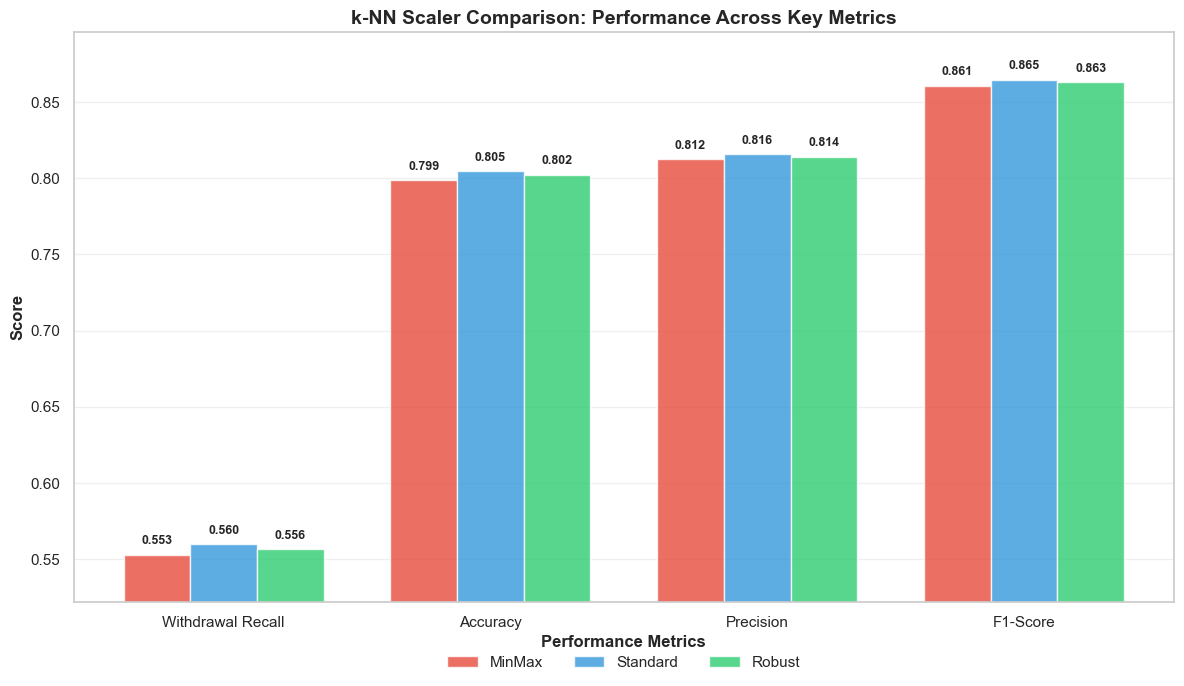


🏆 Winner: Standard
📊 Withdrawal Recall: 0.560
📊 Improvement: +0.007


In [300]:
def scalers_test(X_train, X_test, y_train, y_test):
    """Test MinMax vs Standard vs Robust scalers with clustered bar chart."""
    
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
    from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    
    # Set seaborn theme
    sns.set_theme(style="whitegrid", palette="husl")
    
    results = {}
    
    for name, scaler in [('MinMax', MinMaxScaler()), ('Standard', StandardScaler()), ('Robust', RobustScaler())]:
        
        # Scale numeric features only
        numeric_cols = [0, 1, 2, 3, 4, 5]  # First 6 columns are numeric
        
        # Convert to float to avoid warnings
        X_train_scaled = X_train.astype(float)
        X_test_scaled = X_test.astype(float)
        
        X_train_scaled.iloc[:, numeric_cols] = scaler.fit_transform(X_train_scaled.iloc[:, numeric_cols])
        X_test_scaled.iloc[:, numeric_cols] = scaler.transform(X_test_scaled.iloc[:, numeric_cols])
        
        # Simple k-NN with k=5
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(X_train_scaled, y_train)
        y_pred = knn.predict(X_test_scaled)
        
        # Calculate all metrics
        withdrawal_recall = recall_score(y_test, y_pred, pos_label=0)  # Specificity
        continuation_recall = recall_score(y_test, y_pred, pos_label=1)  # Sensitivity
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        results[name] = {
            'Withdrawal Recall': withdrawal_recall,
            'Accuracy': accuracy,
            'Precision': precision,
            'F1-Score': f1
        }
        
        print(f"{name}: Withdrawal Recall={withdrawal_recall:.3f}, Accuracy={accuracy:.3f}")
    
    # Create DataFrame for plotting
    df = pd.DataFrame(results).T
    
    # Create clustered bar chart
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Set up the bars - metrics on x-axis, scalers as bars
    metrics = df.columns
    scalers = df.index
    x = np.arange(len(metrics))
    width = 0.25  # Narrower bars for 3 scalers
    colors = ['#e74c3c', '#3498db', '#2ecc71']  # Red, Blue, Green
    
    # Plot bars for each scaler
    for i, (scaler, color) in enumerate(zip(scalers, colors)):
        offset = (i - 1) * width  # Center the 3 bars around each metric
        bars = ax.bar(x + offset, df.loc[scaler], width, label=scaler, color=color, alpha=0.8)
        
        # Add value labels on bars
        for j, bar in enumerate(bars):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Customise chart
    ax.set_xlabel('Performance Metrics', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('k-NN Scaler Comparison: Performance Across Key Metrics', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, fontsize=11)


    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07), ncol=3, frameon=False)
    
    # Set y-axis limits: 10% below min, 10% above max
    data_min = df.min().min()
    data_max = df.max().max()
    y_range = data_max - data_min
    ax.set_ylim(data_min - 0.1 * y_range, data_max + 0.1 * y_range)
    
    # Remove gridlines
    ax.grid(True, axis='y', alpha=0.3)  # Only horizontal gridlines
    ax.grid(False, axis='x')            # No vertical gridlines
    
    # Highlight the winner for withdrawal recall
    winner_idx = df['Withdrawal Recall'].idxmax()
    winner_scaler = df.index[df.index == winner_idx][0]
    
    # Add winner annotation
    max_withdrawal = df['Withdrawal Recall'].max()
    # winner_x = list(df.index).index(winner_scaler)
    # ax.annotate(f'🏆 Winner\n{max_withdrawal:.3f}', 
    #             xy=(winner_x - width*2, max_withdrawal), 
    #             xytext=(winner_x - width*2, max_withdrawal + 0.08),
    #             arrowprops=dict(arrowstyle='->', color='red', lw=2),
    #             fontsize=10, fontweight='bold', ha='center',
    #             bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow', alpha=0.7))
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\n🏆 Winner: {winner_scaler}")
    print(f"📊 Withdrawal Recall: {df.loc[winner_scaler, 'Withdrawal Recall']:.3f}")
    print(f"📊 Improvement: +{(df['Withdrawal Recall'].max() - df['Withdrawal Recall'].min()):.3f}")
    
    return df, winner_scaler

results, winner = scalers_test(X_train, X_test, y_train, y_test)